<a href="https://colab.research.google.com/github/tsekine2/Jojo_text_generation/blob/master/jojo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''ライブラリインポート'''
import os
import re
import bs4
import requests
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
import MeCab

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [0]:
'''ジョジョ名言取得'''
with open('jojo.txt', 'a') as f:
  url = 'http://kajipon.sakura.ne.jp/art/jojo9.htm'
  res = requests.get(url)
  res.raise_for_status()

  '''取得したhtmlをparseし、セリフ行のみ取得'''
  soup = bs4.BeautifulSoup(res.content, 'html.parser')
  soup = soup.find_all( text=re.compile("「.+?」+（.+?）+第") )
  
  for s in soup:
    txt = s.__str__()
    '''余分な箇所を削除'''
    txt = re.sub('第.+?巻', '', txt)
    txt = re.sub('（.+?）', '', txt)
    txt = re.sub('※.+', '', txt)
    txt = txt.replace('「', '')
    txt = txt.replace('」', '')
    print(txt)
    f.write(txt)


      なっ！何をするだァーッ！ゆるさんッ！

      さすがディオ！俺達に出来ないことを平然とやってのけるッ！そこにシビれる！あこがれるゥ！

      ディオォォオオーッ！君がッ！泣くまで！殴るのをやめないッ！

      ディオ！おまえのくだらないキスがこれを狙っていたのなら予想以上の効果をあげたぞッ！

      君らとは闘う動機の格が違うんだ！

      ハッタリぬかすなよーッ！金持ちのアマちゃん！

      俺は人間をやめるぞ！ジョジョーッ！！

      ちがうッ！あの父親の精神は…息子のジョナサン・ジョースターが立派に受け継いでいる！それは彼の強い意志となり、誇りとなり、未来となるだろうぜッ！！

      くっそー！侵入罪でとっつかまろーと、この部屋へ入って思いっきり祝ってやるぜーッ！！

      スピードワゴンはクールに去るぜ

      まあ！なんてこと！骨折している腕で私を！いつだって支えるさ

      運命か…人の出会いってのは運命できめられてるのかもしれねえな…

      ウホホホッホッホーッ！

      関節を外して腕をのばすッ！その激痛は波紋エネルギーでやわらげるッ！

      パパウ！パウパウ！波紋カッターッ！！

      お前は今まで食ったパンの枚数を覚えているのか？

      『波紋』？『呼吸法』だと？フーフー吹くなら…このおれのためにファンファーレでも吹いてるのが似合っているぞッ！

      意外！それは髪の毛ッ！

      逆に考えるんだ。“あげちゃってもいいさ”と考えるんだ

      ふるえるぞハート！燃え尽きるほどヒート！！おおおおおっ、刻むぞ血液のビート！山吹き色の波紋疾走！！

      お前…俺が途中で剣撃を止めると…そこまで信用して攻撃してこなかったのか！そこまで人間を信用できるのか！

      三百年たった世界の友人よ。おまえの名をきかせてくれ

      ねーちゃん！あしたって今さッ！こ…こわい…の…は、痛みじゃあ…ないぜ…。ヘ…ヘヘヘヘ…

      自分の運命に満足しておる…すべて受け入れておるよ…わしはこれからお前の中で生きるんじゃ

      そしてジョジョはまた受け継ぐ。彼の生き方とその精神を…

      礼儀を知

In [0]:
'''ファイル読み込み'''
path = './jojo.txt'

'''セリフを行単位で取得'''
nline = 0
with io.open(path, encoding='utf-8') as f:
  lines = f.readlines()
  for line in lines:
    nline += 1
print('行数:', nline)  

'''学習するセンテンスサイズと間隔を設定'''
corpus = []
sentences = []
next_chars = []
maxlen = 3
step = 1

mecab= MeCab.Tagger('-Ochasen')
mecab.parse('')
for line in lines:
  '''行ごとに品詞を取得'''
  corpusl = []
  nodel = mecab.parseToNode(line)
  while nodel:
    corpusl.append(nodel.surface)
    corpus.append(nodel.surface)
    nodel = nodel.next

  '''学習センテンスと教師ラベルを生成'''
  for i in range(0, len(corpusl) - maxlen, step):
    sentences.append(corpusl[i: i + maxlen])
    next_chars.append(corpusl[i + maxlen])
print('センテンス数', len(sentences))
print('単語数　:　', len(corpus))  
print('単語一覧 : ', corpus)

'''単語の重複を削除したコーパスを生成'''
chars = set(corpus)
print('コーパスサイズ　:　', len(chars))
print('コーパス : ', chars)
'''単語→数字と数字→単語に対応した辞書をそれぞれ作成'''
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars)) 

'''ベクトル化'''
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

行数: 283
センテンス数 8136
単語数　:　 8984
単語一覧 :  ['', '', '', 'なっ', '！', '何', 'を', 'する', 'だ', 'ァーッ', '！', 'ゆるさ', 'ん', 'ッ', '！', '', '', 'さすが', 'ディオ', '！', '俺', '達', 'に', '出来', 'ない', 'こと', 'を', '平然と', 'やってのける', 'ッ', '！', 'そこ', 'に', 'シビ', 'れる', '！', 'あこがれる', 'ゥ', '！', '', '', 'ディオォォオオーッ', '！', '君', 'が', 'ッ', '！', '泣く', 'まで', '！', '殴る', 'の', 'を', 'やめ', 'ない', 'ッ', '！', '', '', 'ディオ', '！', 'おまえ', 'の', 'くだらない', 'キス', 'が', 'これ', 'を', '狙っ', 'て', 'い', 'た', 'の', 'なら', '予想', '以上', 'の', '効果', 'を', 'あげ', 'た', 'ぞ', 'ッ', '！', '', '', '君', 'ら', 'と', 'は', '闘う', '動機', 'の', '格', 'が', '違う', 'ん', 'だ', '！', '', '', 'ハッタリ', 'ぬかす', 'な', 'よ', 'ーッ', '！', '金持ち', 'の', 'アマ', 'ちゃん', '！', '', '', '俺', 'は', '人間', 'を', 'やめる', 'ぞ', '！', 'ジョジョーッ', '！', '！', '', '', 'ちがう', 'ッ', '！', 'あの', '父親', 'の', '精神', 'は', '…', '息子', 'の', 'ジョナサン', '・', 'ジョー', 'スター', 'が', '立派', 'に', '受け継い', 'で', 'いる', '！', 'それ', 'は', '彼', 'の', '強い', '意志', 'と', 'なり', '、', '誇り', 'と', 'なり', '、', '未来', 'と', 'なる', 'だろ', 'う', 'ぜ', 'ッ', '！', '！', '', '', 'くっ', 'そ', '

In [0]:
'''LSTMモデル作成'''
model = Sequential()
model.add(LSTM(128, input_shape = (maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               1030144   
_________________________________________________________________
dense_1 (Dense)              (None, 1883)              242907    
Total params: 1,273,051
Trainable params: 1,273,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
'''epoch毎に生成したセリフを表示する関数'''
def on_epoch_end(epoch, _):
  print()
  print('----- %d epoch:' % epoch)

  start_index = random.randint(0, len(corpus) - maxlen -1)
  for diversity in [8.0, 16.0, 32.0, 64.0, 128.0, 256, 512, 1024]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = corpus[start_index: start_index + maxlen]
    generated += ''.join(sentence)
    print('-----シード　"' + ''.join(sentence) + '"　で生成:')
    sys.stdout.write(generated)

    for i in range(10):
      x_pred = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

      preds = model.predict(x_pred, verbose = 0)[0]
      next_index = sample(preds, diversity)
      next_char = indices_char[next_index]

      sentences.append(next_char)

      sys.stdout.write(next_char)
      sys.stdout.flush()
    print()

In [0]:
print_callback = LambdaCallback(on_epoch_end = on_epoch_end)

history = model.fit(x, y, batch_size=128, epochs=60, callbacks=[print_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/60





8136/8136 [==============================] - 10s 1ms/step - loss: 7.1220

----- 0 epoch後に生成されたセリフ:
----- diversity: 8.0
-----シード　"があるし"　で生成:
があるしケツ越えコールタールンッー朝日小便ルート試練ビート
----- diversity: 16.0
-----シード　"があるし"　で生成:
があるしてめえいんひとつ恵みおっ母さんま攻撃バヨリモ
----- diversity: 32.0
-----シード　"があるし"　で生成:
があるしグレート恐れるけなっェェェ年疲れ焼け死ぬ3600ほど
----- diversity: 64.0
-----シード　"があるし"　で生成:
があるし大人最適ラインジョットだめ支えるィィィ国語0烈
----- diversity: 128.0
-----シード　"があるし"　で生成:
があるし人類淹釈迦に対しおまえ映画朝フー・ファイターズきっと崩壊
----- diversity: 256
-----シード　"があるし"　で生成:
があるし夜明け闘いか名生き勢い歩む苦難再はいっ
----- diversity: 512
-----シード　"があるし"　で生成:
があるしタルト法自害部すっごくやる気ケッ思いっきりディオドロローサ
----- diversity: 1024
-----シード　"があるし"　で生成:
があるしW天候落ち00ひとり伝わっ床お許ししとる安らぎ
Epoch 2/60
8136/8136 [==============================] - 1s 105us/step - loss: 5.7638

----- 1 epoch後に生成されたセリフ:
----- diversity: 8.0
-----シード　"られるのか"　で生成:
られるのかかい〜JOJO顔迷惑ノー屈辱渡っまま手
----- diversity: 16.0
-----シード　"

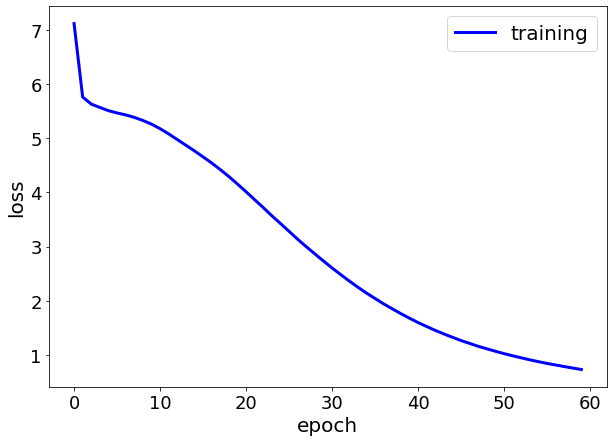

In [0]:
'''loss可視化'''
plt.figure(figsize=(10,7))
loss = history.history['loss']
plt.plot(loss, color='b', linewidth=3)
plt.tick_params(labelsize=18)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['training'], loc='best', fontsize=20)
plt.show()

In [0]:
'''データ保存'''
model.save('jojo-lstm.h5')
model.save_weights('jojo-lstm-weights.h5')